In [2]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image, ImageFilter

In [3]:
def image_resize(image1, image2):
    width1, height1 = image1.size
    width2, height2 = image2.size
    width_min, height_min = min(width1, width2), min(height1, height2)
    image1 = image1.resize((width_min, height_min))
    image2 = image2.resize((width_min, height_min))
    return image1, image2


In [4]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask



In [10]:
def get_statistic(image1, image2):
    fourier_image1 = np.fft.fft2(np.asarray(image1))
    fourier_image2 = np.fft.fft2(np.asarray(image2))
    
    
    image_amp1, image_phase1 = np.absolute(fourier_image1), np.angle(fourier_image1)
    image_amp2, image_phase2 = np.absolute(fourier_image2), np.angle(fourier_image2)
    
    print(f'Max amplitude values - image1: {image_amp1.max()}, image2: {image_amp2.max()}')
    print(f'Max phase values - image1: {image_phase1.max()/np.pi}, image2: {image_phase2.max()/np.pi}') #??
    
    print(f'Min amplitude values - image1: {image_amp1.min()}, image2: {image_amp2.min()}')
    print(f'Min phase values - image1: {image_phase1.min()/np.pi}, image2: {image_phase2.min()/np.pi}') #??
    print()
    
    info_legend = ['20%', '40%', '60%', '80%']
    borders_array_amp1 = [np.percentile(image_amp1, x) for x in (20, 40, 60, 80)]
    for i, val in enumerate(borders_array_amp1):
        print(f'{info_legend[i]} - {val}')
    print()
    
    borders_array_phase1 = [np.percentile(image_phase1, x) for x in (20, 40, 60, 80)]
    for i, val in enumerate(borders_array_phase1):
        print(f'{info_legend[i]} - {val/np.pi}')
        
    
    image_dif_amp = image_amp1 - image_amp2
    image_dif_phase = image_phase1 - image_phase2
    
    
    

    print(np.sum(abs(image_dif_amp) < 1))
    #Нарисовать 3d поверхность, найти пики. 
    #Смонтреть внутри датасета.
    #Замена самые часто встречающиеся (добавить)
    #Замена difa
    #Статистика внутри окружности.



In [11]:
def image_change(image, with_shift=True, phase_change=False, beta=0.1):
    fourier_image = np.fft.fft2(np.asarray(image))
    
    if with_shift:
        fourier_image = np.fft.fftshift(fourier_image)
    
    image_amp, image_phase = np.absolute(fourier_image), np.angle(fourier_image)

    width = fourier_image.shape[0] 
    height = fourier_image.shape[1]
    
    image_changeable = image_phase if phase_change else image_amp
    
    mask = create_circular_mask(width, height, radius=min(width, height)*0.5*beta)
    max_value, min_value = image_changeable.max(), image_changeable.min()

    image_changeable[mask] = np.random.normal(min_value, max_value)

    
    amp, phase = (image_amp, image_changeable) if phase_change else (image_changeable, image_phase)
    fourier_image = amp * np.exp(phase * 1.0j)
   
    if with_shift:
        fourier_image = np.fft.ifftshift(fourier_image)
        
    img = np.abs(np.fft.ifft2(fourier_image))

    return img

In [12]:
def image_style_replace(target, donor, with_shift=True, phase_change=False, beta=0.1):
    fourier_target = np.fft.fft2(np.asarray(target))
    fourier_donor = np.fft.fft2(np.asarray(donor))

    
    if with_shift:
        fourier_target = np.fft.fftshift(fourier_target)
        fourier_donor = np.fft.fftshift(fourier_donor)

    
    image_amp_target, image_phase_target = np.absolute(fourier_target), np.angle(fourier_target)
    image_amp_donor, image_phase_donor = np.absolute(fourier_donor), np.angle(fourier_donor)


    width = fourier_target.shape[0] 
    height = fourier_target.shape[1]
    
    image_changeable_target, image_changeable_donor  = (image_phase_target, image_phase_donor) \
            if phase_change else (image_amp_target, image_amp_donor)
    
    mask = create_circular_mask(width, height, radius=min(width, height)*0.5*beta)

    image_changeable_target[mask] = image_changeable_donor[mask]

    
    amp, phase = (image_amp_target, image_changeable_target) if phase_change \
            else (image_changeable_target, image_phase_target)
    
    fourier_image = amp * np.exp(phase * 1.0j)
   
    if with_shift:
        fourier_image = np.fft.ifftshift(fourier_image)
        
    img = np.abs(np.fft.ifft2(fourier_image))
    
    return img

In [17]:
chess_board = Image.open('images/chess_board.jpg')
chess_board = chess_board.convert('L')


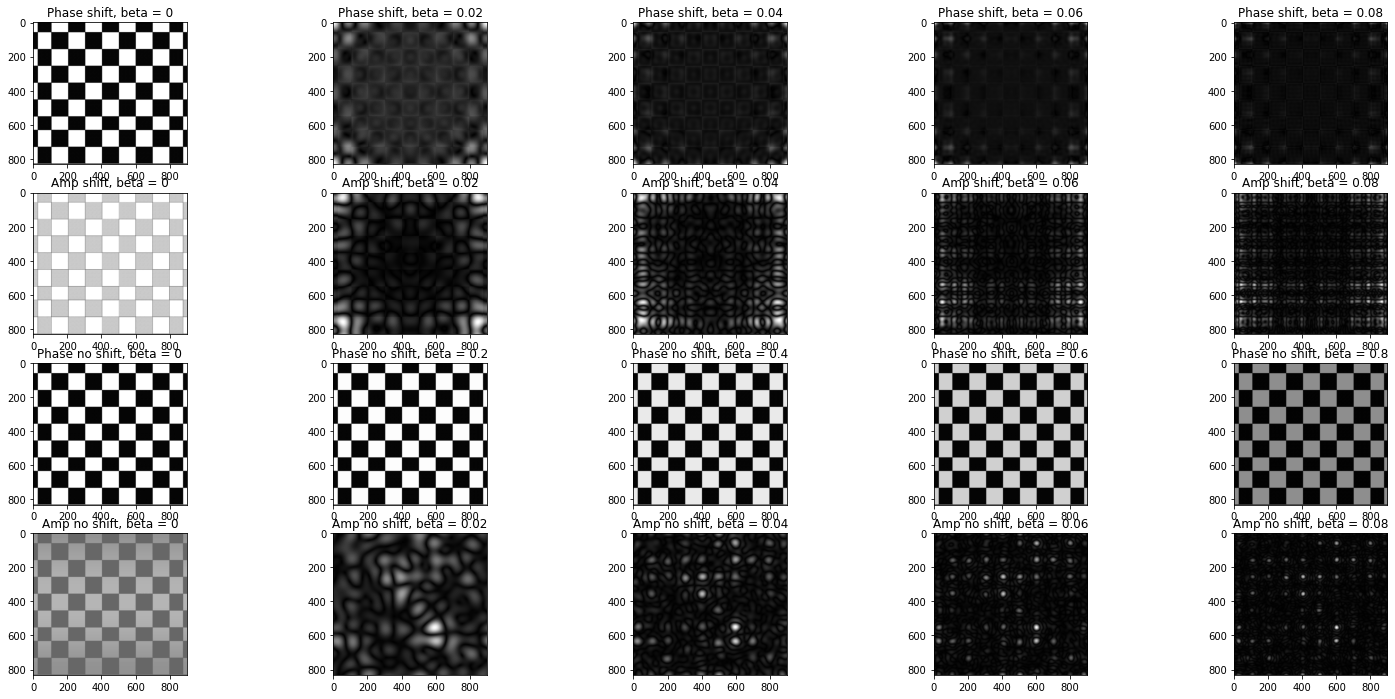

In [19]:
figure, axis = plt.subplots(4, 5, figsize=(26,12))
beta_array = [0, 0.02, 0.04, 0.06, 0.08]

for i in range(5):
    image = image_change(chess_board, with_shift = True, phase_change=True, beta=beta_array[i])
    axis[0,i].imshow(image, cmap='gray')
    axis[0,i].set_title(f'Phase shift, beta = {beta_array[i]}')

for i in range(5):
    image = image_change(chess_board, with_shift = True, phase_change=False, beta=beta_array[i])
    axis[1,i].imshow(image, cmap='gray')
    axis[1,i].set_title(f'Amp shift, beta = {beta_array[i]}')
beta_array = [0, 0.2, 0.4, 0.6, 0.8]

for i in range(5):
    image = image_change(chess_board, with_shift = False, phase_change=True, beta=beta_array[i])
    axis[2,i].imshow(image, cmap='gray')
    axis[2,i].set_title(f'Phase no shift, beta = {beta_array[i]}')
    
beta_array = [0, 0.02, 0.04, 0.06, 0.08]
#Замена и фазы и амплитуды
for i in range(5):
    image = image_change(chess_board, with_shift = False, phase_change=False, beta=beta_array[i])
    axis[3,i].imshow(image, cmap='gray')
    axis[3,i].set_title(f'Amp no shift, beta = {beta_array[i]}')



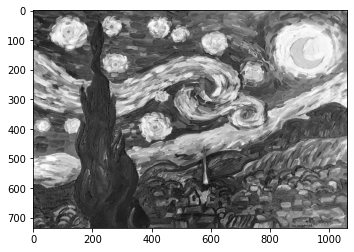

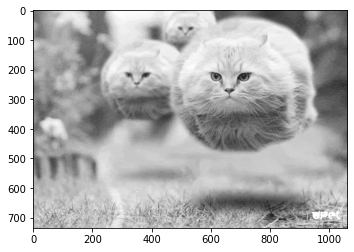

In [14]:
cats = Image.open('images/cats.jpg')
cats = cats.convert('L')
night = Image.open('images/night.jpg')
night = night.convert('L')

cats, night = image_resize(cats, night)
plt.imshow(night, cmap='gray')
plt.show()
plt.imshow(cats, cmap='gray')


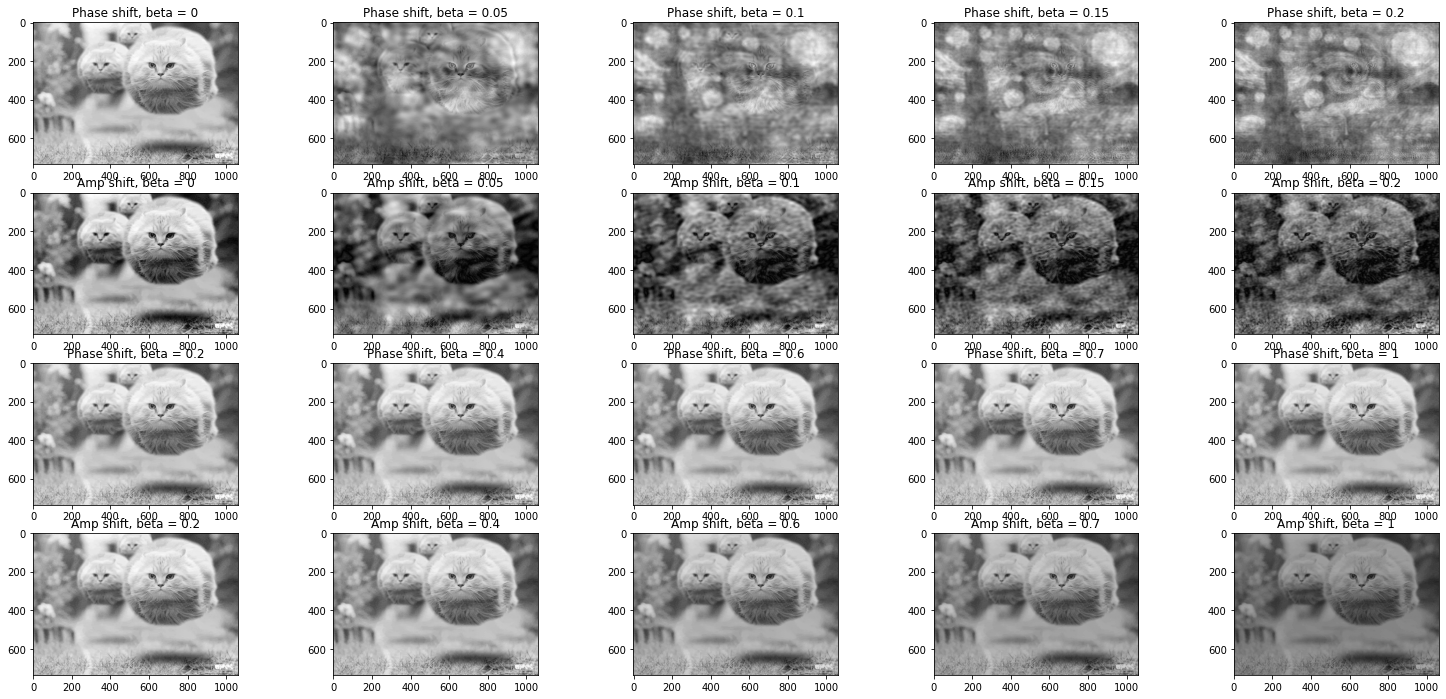

In [188]:
figure, axis = plt.subplots(4, 5, figsize=(26,12))
beta_array = [0, 0.05, 0.1, 0.15, 0.2]

for i in range(5):
    image = image_style_replace(cats, night, with_shift = True, phase_change=True, beta=beta_array[i])
    axis[0,i].imshow(image, cmap='gray')
    axis[0,i].set_title(f'Phase shift, beta = {beta_array[i]}')
    
for i in range(5):
    image = image_style_replace(cats, night, with_shift = True, phase_change=False, beta=beta_array[i])
    axis[1,i].imshow(image, cmap='gray')
    axis[1,i].set_title(f'Amp shift, beta = {beta_array[i]}')
    
beta_array = [0.2, 0.4, 0.6, 0.7, 1]

for i in range(5):
    image = image_style_replace(cats, night, with_shift = False, phase_change=True, beta=beta_array[i])
    axis[2,i].imshow(image, cmap='gray')
    axis[2,i].set_title(f'Phase shift, beta = {beta_array[i]}')
    
for i in range(5):
    image = image_style_replace(cats, night, with_shift = False, phase_change=False, beta=beta_array[i])
    axis[3,i].imshow(image, cmap='gray')
    axis[3,i].set_title(f'Amp shift, beta = {beta_array[i]}')
